# The shape from shading equation

In this notebook, we propose a discretization of the shape from shading PDE, which reads
\begin{equation}
    I(p) = I_0 a \frac{\alpha \partial_x u(p) + \beta \partial_y u(p) + \gamma}{\sqrt{1+\|\nabla u(p)\|^2}}
\end{equation}
for all $p \in \Omega$, and $u(p) = 0$ for all $p \in \partial \Omega$.

we denoted:
- $\Omega\subset \mathbb R^2$ is a bounded domain.
- $u : \Omega \to \mathbb R$ is an unknown surface elevation, to be computed.
- $I_0$ is the light source intensity, and $a$ the albedo of the surface.
- $I: \Omega \to \mathbb R_+$ the reflected intensity.
- The vector $(\alpha, \beta, -\gamma)$ is unit and defines the incident direction of the light rays, and $\gamma>0$. Without loss of generality, up to a reflection of the axes, we can assume that $\alpha\geq 0$ and $\gamma\geq 0$.

The modeling is that the normal to the surface is proportional $(-\nabla u(p), 1)$, hence the deposited light density is proportional to the cosine of the angle difference
\begin{equation}
\frac{(-\nabla u(p),1)}{\sqrt{1+\|\nabla u(p)\|^2}} \cdot (\alpha, \beta, -\gamma).
\end{equation}
We make the assumption $I(p)>0$ everywhere, which amounts to say that no shadows are cast. It implies that the above scalar product is positive.

## Reformulation

We rewrite the PDE as 
\begin{equation}
c(p) \sqrt{1+\|\nabla u(p)\|^2} = (\alpha,\beta) \cdot \nabla u(p) + \gamma,
\end{equation}
where $c(p) :=  I(p)/(I_0 a)$. 

Let us denote this equation as $lhs=rhs$. In order to solve it we need to design a motone scheme for one of the following.

**Note on squaring both sides of the inequality.**
It is very tempting to get rid of the square root, and consider the system $lhs^2 - rhs^2 = 0$, which a quadratic form with respect to $\nabla u(p)$. However, the second degree part needs not be positive definite, unless we do strong assumptions on the coefficients.
After some thinking, this approach is abandoned.


**Discretization.** We thus consider the system $lhs - rhs = 0$, which we discretize as follows:
\begin{equation*}
    c(p)\sqrt{1+(\delta^+_x u(p))^2 + (\delta_y^+ u(p))^2} +\alpha D^+_{-x} u(p) + \beta D^+_{-x} u(p) - \gamma = 0,
\end{equation*}
where we denoted 
\begin{align}
    \delta_x^+ u(p) &:= h^{-1}\max \{0,u(p)-u(p-h e_x), u(p)-u(p+h e_x)\}, \\
    D^+_{-x} u(p) &= h^{-1}(u(p)-u(p+h e_x)),
\end{align}
with $e_x = (1,0)$ the unit vector along the $x$-axis, and $h$ the gridscale. Likewise in the $y$ direction.

**Existence of a solution.** 
The above discrete system of equations admits a  sub-solution and a super solution, obtained as affine functions
\begin{equation}
    u(p) = C + p\cdot v.
\end{equation}

The constant term $C$ should be chosen so as to be below or above zero respectively at the boundary. The gradient should be chosen as follows.
-  sub-solution. Choose $v = (\alpha,\beta)/\gamma$ so that one has the equality $(\alpha,\beta)\cdot v+\gamma = \sqrt{1+\|v\|^2}$ - indeed  $\alpha^2+\beta^2+\gamma^2 =1$ by assumption. Conclude recalling that $c(p)<1$.
-  super-solution. Choose an $v$ such that $(\alpha,\beta) \cdot v + \gamma = 0$. Conclude recalling that $c(p)>0$. 

<!---
\begin{equation}
    c(p)\sqrt{1+\|v\|^2} - (\alpha,\beta)\cdot v -\gamma >0.
\end{equation}

For instance, we can choose a multiple of $(\alpha,\beta)$ with sufficiently large norm. (the vector $v$ can point in an arbitrary direction if $(\alpha,\beta)=0$.
--->

Since the discretization is monotone, there is a solution.

**Jacobi iteration.**
We start with $u_0 = 0$, and iteratively obtain $u_{n+1}$ by solving pointwise a univariate equation. This equation is such that $u_{n+1}(p)$, with neighboring values unchanged, solves the discretized equation.

By monotony of the discretization, and since the initialization is a sub-solution, this  defines an increasing sequence of sub-solutions. The sequence converges, and the limit is a solution.

# Implementation

The jacobi iteration requires solving the following equation
\begin{equation}
    c(p)\sqrt{1+\frac{(\lambda-v_x)^2_+ +(\lambda-v_y)^2_+}{h^2}} + \alpha \frac{\lambda-w_x} h +\beta\frac{\lambda-w_y} h - \gamma = 0,
\end{equation}
where $a_+ := \max{0,a}$ for any $a \in \mathbb R$, and where
\begin{align}
    v_x & := \min\{u(x+h e_x),u(x-he_x)\}, & 
    w_x & := u(x+h e_x),
\end{align}
and likewise for $v_y$, $w_y$.

We write this as $lhs^2 == rhs^2$, solve a quadratic equation. Then we select the single root $\lambda$ such that 
\begin{equation}
\gamma \geq \alpha \frac{\lambda-w_x} h + \beta \frac{\lambda-w_y} h.
\end{equation}
This must be the smallest root.
If the obtained value satisfies $\lambda<v_x$ or $\lambda<v_y$, then the corresponding term is removed from the equation and the process is repeated.

**The quadratic equation.** It reads
\begin{equation*}
c(p)^2 (1+\frac{(\lambda-v_x)^2_+ +(\lambda-v_y)^2_+}{h^2}) - (\alpha \frac{\lambda-w_x} h +\beta\frac{\lambda-w_y} h - \gamma)^2 = 0
\end{equation*}

That is, assuming $\lambda>v_x$ and $\lambda>v_y$,
\begin{equation}
    \lambda^2 (2 c(p)^2  - (\alpha+\beta)^2)
    - 2 \lambda (c(p)^2 (v_x+v_y) - (\alpha+\beta)(\alpha w_x+\beta w_y +h\gamma)) + 
    (c(p)^2 (h^2+v_x^2+v_y^2) - (\gamma h +\alpha w_x+\beta w_y)^2) = 0
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def EvalScheme(cp,u,uc,params):
    alpha,beta,gamma,h = params
    wx = np.roll(u,-1,axis=0)
    wy = np.roll(u,-1,axis=1)
    vx = np.minimum(wx,np.roll(u,1,axis=0))
    vy = np.minimum(wy,np.roll(u,1,axis=1))

    return (cp*np.sqrt(1+(np.maximum(0,uc-vx)**2+np.maximum(0,uc-vy)**2)/h**2) +
            alpha*(uc-wx)/h+beta*(uc-wy)/h-gamma)

In [3]:
def LocalSolve(cp,vx,vy,wx,wy,params):
    alpha,beta,gamma,h = params
    # Trying with two active positive parts
    
    # Quadratic equation coefficients.
    # a lambda^2 - 2 b lambda + c =0
    a = (2.*cp**2 - (alpha+beta)**2)
    b = cp**2 *(vx+vy) - (alpha+beta)*(alpha*wx+beta*wy+h*gamma)
    c = cp**2*(h**2+vx**2+vy**2)-(gamma*h+alpha*wx+beta*wy)**2
    
    delta = b**2 - a*c
    good = np.logical_and(delta>=0,a!=0)
    u = 0*cp;
    # TODO : Is that the correct root selection ?
    u[good] = (b[good]+np.sqrt(delta[good]))/a[good] 

    vmax = np.maximum(vx,vy)
    good = np.logical_and(good,u>=vmax)
    
    # Trying with one active positive part
    # TODO : restrict computations to not good points to save cpu time ?
    
    vmin = np.minimum(vx,vy)
    a = (cp**2 - (alpha+beta)**2)
    b = cp**2 *vmin - (alpha+beta)*(alpha*wx+beta*wy+h*gamma)
    c = cp**2*(h**2+vmin**2)-(gamma*h+alpha*wx+beta*wy)**2

    delta = b**2 - a*c
    ggood = np.logical_and(np.logical_and(delta>=0,a!=0), 1-good)
    u[ggood] = (b[ggood] +np.sqrt(delta[ggood]))/a[ggood]
    
    good = np.logical_or(good,np.logical_and(ggood,u>=vmin))
    
    # No active positive part
    # equation becomes linear, a lambda - b = 0
    a = alpha+beta+0.*cp
    b = alpha*wx+beta*wy +gamma*h - cp*h
    bad = np.logical_not(good)
    u[bad]=b[bad]/a[bad]
    return u
    
def JacobiIteration(u,Omega,c,params):
    wx = np.roll(u,-1,axis=0)
    wy = np.roll(u,-1,axis=1)
    vx = np.minimum(wx,np.roll(u,1,axis=0))
    vy = np.minimum(wy,np.roll(u,1,axis=1))
    
#    sol=LocalSolve(c,vx,vy,wx,wy,params)
    sol = u+LocalSolve(c,vx-u,vy-u,wx-u,wy-u,params)
    u[Omega] = sol[Omega]
    

# Testing

In [4]:
h=1/100.
X,Y = np.meshgrid(np.arange(0,1,h),np.arange(0,1,h))

In [5]:
# The height map


# Three bumps
height = np.maximum(0*X,
                    np.maximum(
                    0.3-3.*((X-0.4)**2+(Y-0.5)**2),
                        np.maximum(
                    0.25-3.*((X-0.65)**2+(Y-0.6)**2),
                    0.25-3.*((X-0.6)**2+(Y-0.35)**2)
                    )))

# Single bump
#height = np.maximum(0*X,0.5-3.*((X-0.5)**2+(Y-0.5)**2))


# Volcano
#R = np.sqrt((X-0.5)**2+(Y-0.5)**2);
#height = np.maximum(0.*X, 0.05+(1+X)*1.5*(R**2-6*R**4) )

Omega = height!=0

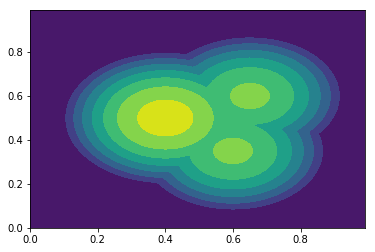

In [6]:
plt.contourf(X,Y,height);

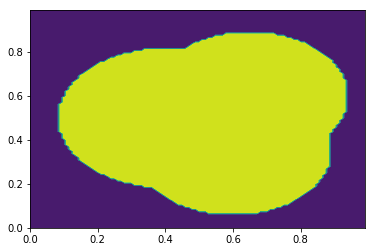

In [7]:
plt.contourf(X,Y,Omega);

In [8]:
# Setting the parameters
omega = 0.15*np.array([1,2]); #0.15
alpha,beta,gamma = np.append(omega,1)/np.linalg.norm(np.append(omega,1))
params = alpha,beta,gamma,h

In [9]:
alpha,beta,gamma

(0.14221363894199318, 0.28442727788398636, 0.9480909262799545)

In [10]:
hx,hy = np.gradient(height,h)
Intensity = (alpha*hx+beta*hy+gamma)/np.sqrt(1+hx**2+hy**2)

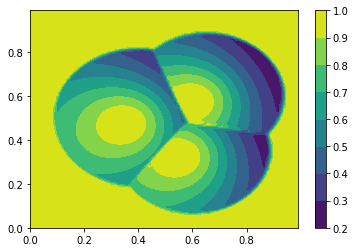

In [11]:
plt.contourf(X,Y,Intensity);plt.colorbar();

In [12]:
# Must be positive
np.min(Intensity[:])

0.2142396137463398

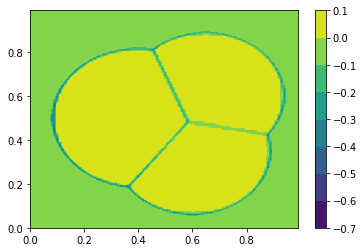

In [13]:
# Must be zero, up to first order approx of derivatives
plt.contourf(X,Y,EvalScheme(Intensity,height,height,[alpha,beta,gamma,h]));
plt.colorbar();

In [18]:
U=1.+0.*X; U[np.logical_not(Omega)]=0; # Start with an overestimate : fast convergence
#U=0.*X;  # Start with an under-estimate : slow convergence
JacobiIteration(U,Omega,Intensity,[alpha,beta,gamma,h])

In [26]:
for i in range(200):
    JacobiIteration(U,Omega,Intensity,[alpha,beta,gamma,h])

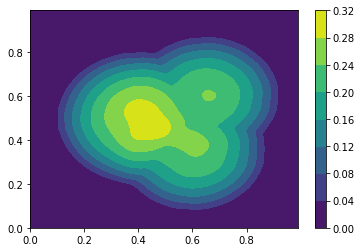

In [27]:
plt.contourf(X,Y,U); plt.colorbar();

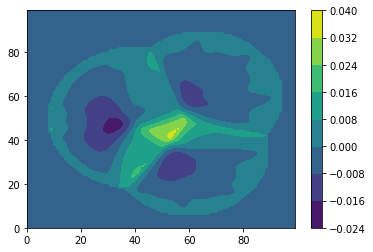

In [17]:
plt.contourf(U-height);plt.colorbar();

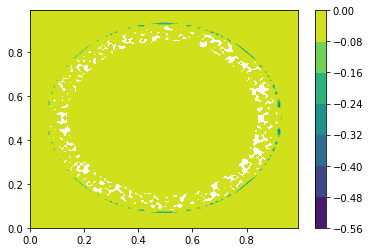

In [48]:
plt.contourf(X,Y,EvalScheme(Intensity,U,U,[alpha,beta,gamma,h])); plt.colorbar();

In [49]:
np.max(EvalScheme(Intensity,U,U,[alpha,beta,gamma,h])[Omega])

2.220446049250313e-15

Works, but many iterations are needed, and accuracy is not super-great.

Interestingly, we do find the volcano even when the rays are from above. Note that the PDE is degenerate in that case, due to the horizontal part on top.

# What next ?

Iterations are rather fast, so their number may not be an issue.
Otherwise, we could try a Newton method...
Improving the accuracy would require a non-monotone method.